<a href="https://colab.research.google.com/github/singhaniasnigdha/food-rec/blob/main/Recipe_Recommendation_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/maciejkula/spotlight.git@master#egg=spotlight

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')
nltk.download('stopwords')


from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords

from spotlight.interactions import Interactions, SequenceInteractions
from spotlight.cross_validation import random_train_test_split
from spotlight.evaluation import mrr_score, precision_recall_score, sequence_mrr_score
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.sequence.implicit import ImplicitSequenceModel

from sklearn.preprocessing import LabelEncoder
from collections import Counter
from copy import deepcopy
from pprint import pprint

import string
import torch
import warnings
warnings.simplefilter('ignore')

from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/My Drive/AML/Food.com/'
# root_path = '/content/drive/My Drive/Food.com/'

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ps = PorterStemmer()
en_stopwords = stopwords.words('english')
en_punctuations = str.maketrans('', '', string.punctuation)

def preprocess(text):
  text = text.strip().lower().translate(en_punctuations)

  # Stem and remove stopwords
  stemmed = [ps.stem(token) for token in text.split() if token not in en_stopwords]

  # Remove single chars
  return [token for token in stemmed if len(token) > 1]

#Create an inverted index - from word to recipe_id
def create_inverted_index(recipes):
  inv_idx = {} 
  for index, row in recipes.iterrows():
    for item in row['text']: 
        if item not in inv_idx: 
          inv_idx[item] = set()
        inv_idx[item].add(row['id'])
 
  return inv_idx

class value_encoder:
  def __init__(self):
    self.value_map = {}

  def fit(self, data):
    counter = 1
    for val in sorted(deepcopy(data)):
      if val not in self.value_map:
        self.value_map[val] = counter
        counter += 1
  
  def transform(self, val):
    return self.value_map.get(val, 0)

  def get_size(self):
    return len(self.value_map)

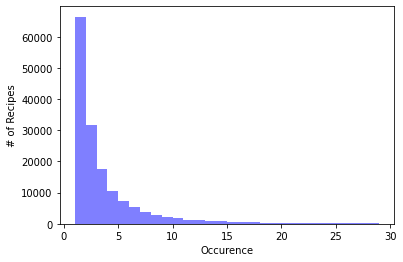

(1513,)


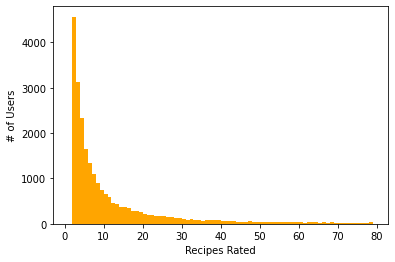

In [ ]:
interactions_train = pd.read_csv(root_path + 'interactions_train.csv')

# Data Pre-processing
# Remove movies that occur <= 2 times
freq = interactions_train['recipe_id'].value_counts()

n, bins, patches = plt.hist(freq.to_list(), bins=range(1,30,1), facecolor='blue', alpha=0.5)
plt.ylabel('# of Recipes')
plt.xlabel('Occurence')
plt.show()

freq_user = interactions_train['user_id'].value_counts()

# interactions_train[]
print(freq_user[freq_user > 75].shape)
# print(interactions_train['user_id'].isin(.index))
n, bins, patches = plt.hist(freq_user.to_list(), bins=range(1, 80, 1), facecolor='orange')
plt.ylabel('# of Users')
plt.xlabel('Recipes Rated')
plt.show()

In [ ]:
interactions = pd.read_csv(root_path + 'interactions_train.csv')
print(f'{interactions["user_id"].nunique()} -- {interactions["recipe_id"].nunique()}')

# Data Pre-processing
# Remove recipes that occur <= 3 times
freq_user = interactions['user_id'].value_counts()
interactions = interactions[interactions['user_id'].isin(freq_user[freq_user > 3].index)]
interactions = interactions[interactions['user_id'].isin(freq_user[freq_user < 75].index)]
freq_recipe = interactions['recipe_id'].value_counts()
interactions = interactions[interactions['recipe_id'].isin(freq_recipe[freq_recipe > 3].index)]

freq_user = interactions['user_id'].value_counts()
interactions = interactions[interactions['user_id'].isin(freq_user[freq_user > 3].index)]

print('After pre-processing')
print(f'{interactions["user_id"].nunique()} -- {interactions["recipe_id"].nunique()}')

# Create Dataset
clickstream_tr = interactions[['user_id', 'recipe_id', 'date','rating']]
clickstream_tr['date'] = pd.to_datetime(clickstream_tr['date'])

user_lr = value_encoder()
user_lr.fit(clickstream_tr['user_id'].unique())
clickstream_tr['user_id'] = clickstream_tr['user_id'].apply(user_lr.transform)

recipe_lr = value_encoder()
recipe_lr.fit(clickstream_tr['recipe_id'].unique())
clickstream_tr['recipe_id'] = clickstream_tr['recipe_id'].apply(recipe_lr.transform)

'''
Split into training and test
'''
clickstream_tr = clickstream_tr.sort_values(by=['user_id', 'date'])
data_test = clickstream_tr.groupby(by='user_id').tail(1)
data_train = clickstream_tr.drop(data_test.index)

n_users = clickstream_tr['user_id'].max()
n_items = clickstream_tr['recipe_id'].max()

# For Spotlight
train = Interactions(data_train['user_id'].values, data_train['recipe_id'].values, data_train['rating'].values, 
                     data_train['date'].values, num_items=n_items+1)

test = Interactions(data_test['user_id'].values, data_test['recipe_id'].values, 
                              data_test['rating'].values, data_test['date'].values, 
                              num_users=train.num_users, num_items=train.num_items)
print(train, test)

# Recipes seen by User in training
seen_recipes = data_train.groupby(by='user_id')['recipe_id'].apply(list).to_dict()

c=0
for k, v in seen_recipes.items():
  if len(v) != len(set(v)):
    c+=1
print(f'C={c}')

# Sparsity
sp = float(len(clickstream_tr))/(n_users * n_items)
print(f'Sparsity = {1 - sp}, Interactions = {len(clickstream_tr)}')

25076 -- 160901
After pre-processing
12840 -- 12353
<Interactions dataset (12841 users x 12354 items x 138235 interactions)> <Interactions dataset (12841 users x 12354 items x 12840 interactions)>
C=0
Sparsity = 0.9990475215953949, Interactions = 151075


In [ ]:
def print_scores(test_user_ids, test_item_ids, user_to_idx, preds):
  hr = 0.0
  mrr = 0.0
  for u, i in zip(test_user_ids, test_item_ids):
    matched_preds = preds[user_to_idx[u]] == i
    temp_hr = matched_preds.sum()
    if temp_hr:
      hr += 1
      mrr += (1 / float(matched_preds.nonzero()[0][0] + 1))
      # ndcg += (math.log(2) / math.log(rank + 2))

  print(f"\nHit Rate (%): {(float(hr) / len(test_user_ids)) * 100}")
  print(f"MRR: {(float(mrr) / len(test_user_ids))}\n")

def get_preds(model, test_set):
  user_to_idx = {}
  preds = np.zeros((len(set(test_set.user_ids)), 50))
  scores = np.zeros_like(preds)
  for idx, user in enumerate(set(test_set.user_ids)):
    user_to_idx[user] = idx
    p = model.predict(user)
    # Setting score of seen recipes to -1
    p[seen_recipes[user]] = p.min()
    preds[idx] = np.argpartition(p, -50)[-50:]
    scores[idx] = p[preds[idx].astype(int)]

  x = np.arange(scores.shape[0]).reshape(-1, 1)
  y = np.flip(scores.argsort(), axis=-1)

  sorted_preds = preds[x, y].astype(int)
  return sorted_preds, user_to_idx

def test_implicit_factorization_model(train_set, test_set, loss_fn='hinge', epochs=10, l2=0, num_negative=5):
  model = ImplicitFactorizationModel(loss=loss_fn, use_cuda=True, n_iter=epochs, l2=l2, num_negative_samples=num_negative)
  model.fit(train_set, verbose=False)

  sorted_preds, user_to_idx = get_preds(model, train_set)
  print_scores(test_set.user_ids, test_set.item_ids, user_to_idx, sorted_preds)
  # print("MRR2", np.mean(mrr_score(model, test)))

def test_explicit_factorization_model(train, test, loss_fn='regression', epochs=10):
  model = ExplicitFactorizationModel(loss=loss_fn, use_cuda=True, n_iter=epochs)
  model.fit(train, verbose=True)

  sorted_preds, user_to_idx = get_preds(model, test)
  print_scores(test.user_ids, test.item_ids, user_to_idx, sorted_preds)

# train, test = random_train_test_split(dataset_tr, test_percentage=0.05)

In [ ]:
'''
Most Popular Baseline Result
'''
import math

most_popular = Counter(train.item_ids).most_common(50)
top_ids, _ = zip(*most_popular)
top_ids = np.asarray(top_ids).tolist()

hr = 0.0
mrr = 0.0
ndcg = 0.0
count = 0
for u, i in zip(test.user_ids, test.item_ids):
  count += 1
  if i in top_ids:
    hr += 1
    rank = top_ids.index(i)
    mrr += (1.0 / (rank + 1))
    ndcg += (math.log(2) / math.log(rank + 2))

print('---------------------- Most Popular Baseline --------------------')
print(f"Hit Rate (%): {(hr / count) * 100}")
print(f"MRR: {(mrr / count)}")
print(f"NDCG: {(ndcg) / count}")

---------------------- Most Popular Baseline --------------------
Hit Rate (%): 10.607476635514018
MRR: 0.014260101503560758
NDCG: 0.03197242569599709


In [ ]:
# Creating a markov chain for movie transitions (Ranking)
trans_dict = {}
sequences = train.to_sequence(260).sequences
for sequence in sequences:
  for i in range(len(sequence) - 1):
    if sequence[i] != 0:
      this_item, next_item = sequence[i:i+2]
      if this_item not in trans_dict:
        trans_dict[this_item] = {}
      if next_item not in trans_dict[this_item]:
        trans_dict[this_item][next_item] = 0
      trans_dict[this_item][next_item] += 1

# Last items
last_items = dict(zip(list(range(sequences.shape[0])), sequences[:, -1]))

# Conditional Probability Model
cp_preds = {} 

# Conditional Probability + Most Popular Model
cp_mp_preds = {} 

# Most Popular
mp_preds = {} 
for u, i in last_items.items():
  if i in trans_dict:
    preds = sorted(trans_dict[i], key=trans_dict[i].get, reverse=True)[:50]
  else:
    preds = []
  cp_preds[u] = np.asarray(preds)
  cp_mp_preds[u] = np.asarray((preds + top_ids)[:50])
  mp_preds[u] = np.asarray(top_ids)
mp_preds[-1] = cp_mp_preds[-1] = cp_preds[-1] = np.asarray(top_ids)

In [ ]:
def print_scores_2(test_user_ids, test_item_ids, preds):
  hr = 0.0
  mrr = 0.0
  for u, i in zip(test_user_ids, test_item_ids):
    matched_preds = preds[u-1] == i
    temp_hr = matched_preds.sum()
    if temp_hr:
      hr += 1
      mrr += (1 / float(matched_preds.nonzero()[0][0] + 1))

  print(f"\nHit Rate (%): {(float(hr) / len(test_user_ids)) * 100}")
  print(f"MRR: {(float(mrr) / len(test_user_ids))}\n")

print("MP")
print_scores_2(test.user_ids, test.item_ids, mp_preds)
print("CP")
print_scores_2(test.user_ids, test.item_ids, cp_preds)
print("CP + MP")
print_scores_2(test.user_ids, test.item_ids, cp_mp_preds)

MP

Hit Rate (%): 10.607476635514018
MRR: 0.014260101503560758

CP

Hit Rate (%): 2.2819314641744546
MRR: 0.005216572742125231

CP + MP

Hit Rate (%): 7.20404984423676
MRR: 0.007832505949785726



In [ ]:
# Validation Set
data_val = data_train.groupby(by='user_id').tail(1)
data_train_val = data_train.drop(data_val.index)

# For validation
val = Interactions(data_val['user_id'].values, data_val['recipe_id'].values, 
                      data_val['rating'].values, data_val['date'].values, 
                      num_users=train.num_users, num_items=train.num_items)

train_val = Interactions(data_train_val['user_id'].values, data_train_val['recipe_id'].values, 
                      data_train_val['rating'].values, data_train_val['date'].values, 
                      num_users=train.num_users, num_items=train.num_items)

seen_recipes = data_train_val.groupby(by='user_id')['recipe_id'].apply(list).to_dict()

print('--------------------FOR VALIDATION---------------------')

for fn in ['pointwise', 'bpr', 'hinge', 'adaptive_hinge']:
  for num_negative in [5, 10]:
    for l2 in [0.001, 0.0005]:
      for epochs in [2, 5, 10]:
        print(f"Loss fn: {fn}\tNum Neg: {num_negative}\tL2: {l2}\tEpochs: {epochs}")
        test_implicit_factorization_model(train_val, val, loss_fn=fn, epochs=epochs, l2=l2, num_negative=num_negative)

print('--------------------FOR VALIDATION---------------------')

--------------------FOR VALIDATION---------------------
Loss fn: pointwise	Num Neg: 5	L2: 0.001	Epochs: 2

Hit Rate (%): 10.28816199376947
MRR: 0.014091292761302788

Loss fn: pointwise	Num Neg: 5	L2: 0.001	Epochs: 5

Hit Rate (%): 10.15576323987539
MRR: 0.014156901097313304

Loss fn: pointwise	Num Neg: 5	L2: 0.001	Epochs: 10

Hit Rate (%): 10.023364485981308
MRR: 0.01404173900184252

Loss fn: pointwise	Num Neg: 5	L2: 0.0005	Epochs: 2

Hit Rate (%): 10.327102803738319
MRR: 0.01410837533278571

Loss fn: pointwise	Num Neg: 5	L2: 0.0005	Epochs: 5

Hit Rate (%): 10.397196261682243
MRR: 0.014208265700949043

Loss fn: pointwise	Num Neg: 5	L2: 0.0005	Epochs: 10

Hit Rate (%): 10.537383177570094
MRR: 0.014296737293200797

Loss fn: pointwise	Num Neg: 10	L2: 0.001	Epochs: 2

Hit Rate (%): 10.101246105919003
MRR: 0.014130585038942874

Loss fn: pointwise	Num Neg: 10	L2: 0.001	Epochs: 5

Hit Rate (%): 10.085669781931465
MRR: 0.014071219772140682

Loss fn: pointwise	Num Neg: 10	L2: 0.001	Epochs: 10



In [ ]:
seen_recipes = data_train.groupby(by='user_id')['recipe_id'].apply(list).to_dict()

for fn in ['pointwise', 'bpr', 'hinge', 'adaptive_hinge']:
  for num_negative in [5, 10]:
    for l2 in [0.001, 0.0005]:
      for epochs in [2, 5, 10]:
        print(f"Loss fn: {fn}\tNum Neg: {num_negative}\tL2: {l2}\tEpochs: {epochs}")
        test_implicit_factorization_model(train, test, loss_fn=fn, epochs=epochs, l2=l2, num_negative=num_negative)

Loss fn: pointwise	Num Neg: 5	L2: 0.001	Epochs: 2

Hit Rate (%): 10.638629283489097
MRR: 0.015277201754283863

Loss fn: pointwise	Num Neg: 5	L2: 0.001	Epochs: 5

Hit Rate (%): 10.537383177570094
MRR: 0.014717798073909084

Loss fn: pointwise	Num Neg: 5	L2: 0.001	Epochs: 10

Hit Rate (%): 10.389408099688474
MRR: 0.014986265749929574

Loss fn: pointwise	Num Neg: 5	L2: 0.0005	Epochs: 2

Hit Rate (%): 10.700934579439252
MRR: 0.014722338080026993

Loss fn: pointwise	Num Neg: 5	L2: 0.0005	Epochs: 5

Hit Rate (%): 10.623052959501559
MRR: 0.0147370614229712

Loss fn: pointwise	Num Neg: 5	L2: 0.0005	Epochs: 10

Hit Rate (%): 10.56853582554517
MRR: 0.014635991518903761

Loss fn: pointwise	Num Neg: 10	L2: 0.001	Epochs: 2

Hit Rate (%): 10.44392523364486
MRR: 0.013983305111745415

Loss fn: pointwise	Num Neg: 10	L2: 0.001	Epochs: 5

Hit Rate (%): 10.30373831775701
MRR: 0.015302441040298976

Loss fn: pointwise	Num Neg: 10	L2: 0.001	Epochs: 10

Hit Rate (%): 10.498442367601246
MRR: 0.01544698411777532

In [ ]:
for fn in ['regression', 'poisson', 'logistic']:
  print(f'------Explicit Factorization Method: Loss Function={fn}-------')
  test_explicit_factorization_model(train, test, loss_fn=fn)

------Explicit Factorization Method: Loss Function=regression-------
Epoch 0: loss 9.776066818609955
Epoch 1: loss 1.1081107705955777
Epoch 2: loss 0.6156715122766689
Epoch 3: loss 0.7211433105045685
Epoch 4: loss 0.936099849948301
Epoch 5: loss 0.9104374224180984
Epoch 6: loss 0.778397850513648
Epoch 7: loss 0.70985361409786
Epoch 8: loss 0.7039559431249257
Epoch 9: loss 0.7022713698991591
[0.9768079 3.5267205 2.9854937 ... 2.9182177 1.1825607 1.0822166] 20764

Hit Rate (%): 0.4260567328175804
MRR: 0.0005665825301837481

------Explicit Factorization Method: Loss Function=poisson-------
Epoch 0: loss -1.390158524161724
Epoch 1: loss -2.0477400519863136
Epoch 2: loss -1.9588017266135878
Epoch 3: loss -2.0536045323077388
Epoch 4: loss -2.127329597436816
Epoch 5: loss -2.153932251793853
Epoch 6: loss -2.1467087687356017
Epoch 7: loss -2.1228031622109826
Epoch 8: loss -2.1013391063119102
Epoch 9: loss -2.089616117025768
[1.6541837 2.7337024 3.3395739 ... 3.477845  3.026468  1.7070392] 2076

In [ ]:
from spotlight.evaluation import sequence_mrr_score

seq_all = dataset_tr.to_sequence(max_sequence_length=25)

test_size = 10000
seq_train, seq_val = seq_all.sequences[:, :-2], seq_all.sequences[:, -2]
seq_test_idx = np.random.choice(len(seq_test), test_size, replace=False)

mrr_scores = {}

for rep in ['cnn', 'pooling', 'lstm', 'mixture']:
  for fn in ['pointwise', 'bpr', 'hinge', 'adaptive_hinge']:
    seq_model = ImplicitSequenceModel(n_iter=10, representation=rep, loss=fn, use_cuda=True)
    seq_model.fit(SequenceInteractions(seq_train))

    mrr = sequence_mrr_score(seq_model, SequenceInteractions(seq_all.sequences[seq_test_idx]))
    key = f'{rep}-{fn}'
    import pdb
    pdb.set_trace()
    mrr_scores[key] = np.mean(mrr)
    print(f'Complete - {key} -- {mrr_scores[key]}')

print('\n------------- FINALLY-----------------')
print(mrr_scores)

In [ ]:
'''
Implicit Sequence Models
'''
seq_all = train.to_sequence(max_sequence_length=25)

test_size = 10000
seq_train, seq_val = seq_all.sequences[:, :-1], seq_all.sequences[:, -1]
seq_test_idx = np.random.choice(len(seq_val), test_size, replace=False)

# user_to_item = dict(zip(test.user_ids, test.item_ids))
# labels = [user_to_item[idx] if idx in user_to_item else None for idx in range(seq_test.shape[0])]

seq_mrr_scores = {}
seq_hit_rate = {}

for fn in ['pointwise', 'bpr', 'hinge', 'adaptive_hinge']:
  for rep in ['cnn', 'pooling', 'lstm', 'mixture']:
    for num_negative in [5, 10]:
      for l2 in [0.001, 0.0005]:
        for epochs in [2, 5, 10]:
          seq_model = ImplicitSequenceModel(n_iter=epochs, representation=rep, 
                                            loss=fn, use_cuda=True, l2=l2, 
                                            num_negative_samples=num_negative)
          seq_model.fit(SequenceInteractions(seq_train))

          preds = np.zeros((test_size, 50))
          scores = np.zeros_like(preds)
          for idx in range(test_size):
            p = seq_model.predict(seq_train[seq_test_idx[i]][-25:])
            # p[seen_recipes[idx]] = p.min()
            preds[idx] = np.argpartition(p, -50)[-50:]
            scores[idx] = p[preds[idx].astype(int)]
          x = np.arange(scores.shape[0]).reshape(-1, 1)
          y = np.flip(scores.argsort(), axis=-1)
          sorted_preds = preds[x, y].astype(int)

          hr = 0
          mrr = 0
          for idx in range(test_size):
            matched_preds = preds[idx] == seq_val[idx]
            
            temp_hr = matched_preds.sum()
            if temp_hr:
              hr += 1
              mrr += (1 / float(matched_preds.nonzero()[0][0] + 1))
          
          print(f"Loss fn: {fn}\tRep: {rep}\tNum Neg: {num_negative}\tL2: {l2}\tEpochs: {epochs}")
          print(f"MRR: {float(mrr) / test_size}")
          print(f"HR: {float(hr) * 100 / test_size}")

# for rep in ['cnn', 'pooling', 'lstm', 'mixture']:
# # for rep in ['pooling']:
#   for fn in ['pointwise', 'bpr', 'hinge', 'adaptive_hinge']:
#     seq_model = ImplicitSequenceModel(n_iter=5, representation=rep, loss=fn, use_cuda=True, l2=0.005, num_negative_samples=100)
#     seq_model.fit(seq_train)

#     preds = np.zeros((seq_test.shape[0], 50))
#     scores = np.zeros_like(preds)
#     for idx in range(1, seq_test.shape[0]):
#       p = seq_model.predict(seq_test[idx][-25:])
#       p[seen_recipes[idx]] = p.min()
#       preds[idx] = np.argpartition(p, -50)[-50:]
#       scores[idx] = p[preds[idx].astype(int)]

#     x = np.arange(scores.shape[0]).reshape(-1, 1)
#     y = np.flip(scores.argsort(), axis=-1)
#     sorted_preds = preds[x, y].astype(int)

#     hr = 0
#     mrr = 0
#     for idx in range(1, seq_test.shape[0]):
#       matched_preds = preds[idx] == labels[idx]
      
#       temp_hr = matched_preds.sum()
#       if temp_hr:
#         hr += 1
#         mrr += (1 / float(matched_preds.nonzero()[0][0] + 1))

#     # key = f'{rep}-{fn}'
#     # print(seq_test.shape[0])
#     # seq_mrr_scores[key] = (float(mrr) / seq_test.shape[0])
#     # seq_hit_rate[key] = float(hr)* 100 / seq_test.shape[0]
#     # print(f'Complete - {key} -- {seq_mrr_scores[key]:.4f} -- {seq_hit_rate[key]:.4f}%')

# print('\n------------- FINALLY-----------------')
# print(seq_mrr_scores)

In [ ]:
'''
Implicit Sequence Models
'''
seq_all = train.to_sequence(max_sequence_length=25)
seq_full = train.to_sequence(max_sequence_length=150).sequences
labels = test.item_ids.tolist()
def seq_train_test(fn, rep, num_neg, l2, epoch):
  seq_model = ImplicitSequenceModel(n_iter=epoch, representation=rep, 
                                    loss=fn, use_cuda=True, l2=l2, 
                                    num_negative_samples=num_neg)
  seq_model.fit(seq_all)
  preds = np.zeros((len(labels), 50))
  scores = np.zeros_like(preds)
  for idx in range(len(labels)):
    p = seq_model.predict(seq_full[idx][-25:])
    preds[idx] = np.argpartition(p, -50)[-50:]
    scores[idx] = p[preds[idx].astype(int)]
  x = np.arange(scores.shape[0]).reshape(-1, 1)
  y = np.flip(scores.argsort(), axis=-1)
  sorted_preds = preds[x, y].astype(int)
  print(sorted_preds)

  hr = 0
  mrr = 0
  for idx in range(len(labels)):
    matched_preds = preds[idx] == labels[idx]
    
    temp_hr = matched_preds.sum()
    if temp_hr:
      hr += 1
      mrr += (1 / float(matched_preds.nonzero()[0][0] + 1))
  
  print(f"Loss fn: {fn}\tRep: {rep}\tNum Neg: {num_neg}\tL2: {l2}\tEpochs: {epoch}")
  print(f"MRR: {float(mrr) / len(labels)}")
  print(f"HR: {float(hr) * 100 / len(labels)}")


seq_train_test('adaptive_hinge', 'cnn', 10, 0.001, 5)
seq_train_test('pointwise', 'pooling', 5, 0.001, 10)
seq_train_test('adaptive_hinge', 'lstm', 10, 0.001, 10)
seq_train_test('adaptive_hinge', 'mixture', 10, 0.0005, 10)


[[6584 2823 5390 ... 2864 6934  268]
 [6584 2823 5390 ... 2864 6934  268]
 [6584 2823 5390 ... 2864 6934  268]
 ...
 [2823 6584 5390 ... 2864 6934  268]
 [6584 2823 5390 ... 2864 6934  268]
 [6584 2823 5390 ... 2864 6934  268]]
Loss fn: adaptive_hinge	Rep: cnn	Num Neg: 10	L2: 0.001	Epochs: 5
MRR: 0.007104250767897868
HR: 10.607476635514018


KeyboardInterrupt: ignored

Complete - cnn-pointwise -- 0.0067 -- 9.2723%
Complete - cnn-bpr -- 0.0063 -- 9.2163%
Complete - cnn-hinge -- 0.0053 -- 7.0299%
Complete - cnn-adaptive_hinge -- 0.0064 -- 9.4966%
Complete - pooling-pointwise -- 0.0062 -- 9.3508%
Complete - pooling-bpr -- 0.0056 -- 9.1658%
Complete - pooling-hinge -- 0.0066 -- 9.6872%
Complete - pooling-adaptive_hinge -- 0.0062 -- 9.6760%
Complete - lstm-pointwise -- 0.0058 -- 8.8743%
Complete - lstm-bpr -- 0.0065 -- 9.1434%
Complete - lstm-hinge -- 0.0049 -- 6.4918%
Complete - lstm-adaptive_hinge -- 0.0059 -- 9.5134%
Complete - mixture-pointwise -- 0.0065 -- 9.5022%
Complete - mixture-bpr -- 0.0057 -- 9.2051%
Complete - mixture-hinge -- 0.0058 -- 7.9101%
Complete - mixture-adaptive_hinge -- 0.0066 -- 9.6816%

In [ ]:
'''
Run this if pre-processing data for the first time.
Otherwise, read the data from pre-processed file, which is created at the end of this block
'''
recipes = pd.read_csv(root_path + 'RAW_recipes.csv')

recipes = recipes[recipes['id'].isin(interactions['recipe_id'])]
recipes['id'] = recipes['id'].apply(recipe_lr.transform)
recipes['tags'] = recipes['tags'].apply(eval)
recipes['tags_str'] = recipes['tags'].apply(lambda x: ' '.join(x))
recipes['ingredients_str'] = recipes['ingredients'].apply(lambda x: ' '.join(x))
recipes['calories'] = recipes['nutrition'].apply(lambda x: eval(x)[0])

# Creating a text field - which combines name, description, tags and ingredients
recipes['text'] = recipes[['name', 'tags_str', 'description', 'ingredients_str']].values.tolist()
recipes['text'] = recipes['text'].apply(lambda t: preprocess(' '.join(map(str, t))))
 
inv_idx = create_inverted_index(recipes)

'''
Writing Inverted Index and updated recipes df to csv.
Will make experimentation faster, as we dont need to do the calculation everytime.
'''
import pickle
with open(root_path + 'inv_idx.pkl', 'wb') as f:
  pickle.dump(inv_idx, f)
recipes.to_csv(root_path + 'processed_recipes.csv', index=False)

In [ ]:
'''
Read pre-process recipes from file
'''
recipes = pd.read_csv(root_path + 'processed_recipes.csv')
inv_idx = pd.read_pickle(root_path + 'inv_idx.pkl')

In [ ]:
'''
Process User Input (string + calories) and get candidate IDs
'''
loaded_scores = np.load(root_path + 'user_scores.npy') 
def predict_recipes(user_id, cals, meal_query, model):
  # Get Candidates
  pp_meal_query = preprocess(meal_query)

  # Create score placeholders
  num_items = recipes['id'].nunique()
  calorie_scores = np.zeros(num_items + 1) # They are encoded from 1
  text_scores = np.zeros(num_items + 1)

  # Scores based on calorie filtering
  candidate_cals = recipes[recipes['calories'] <= cals]['id'].values.tolist()
  calorie_scores[candidate_cals] = 1

  # Counting the ids per keyword, used to rank entries
  candidates, score = zip(*Counter([idx for token in pp_meal_query for idx in inv_idx[token]]).most_common())
  text_scores[list(candidates)] = list(score)

  # Scores from model
  model_scores = np.asarray([0] + loaded_scores[user_id - 1].tolist())
  # model_scores = model.predict(user_id)
  top_idx = np.lexsort((-model_scores, -text_scores, -calorie_scores))[:10]
  # top_idx = np.argsort(-model_scores)[:10]

  pprint([recipes.loc[recipes['id'] == idx]['name'].values[0] for idx in top_idx])

In [ ]:
top_r, top_c = zip(*Counter(test.item_ids).most_common(50))
print(len(set(top_r).intersection(np.argsort(seq_model.predict(seqs[1][-25:]))[::-1][:50])))
print(sum(top_c))

42
1433


In [ ]:
df_inter = Interactions(clickstream_tr['user_id'].values, 
                        clickstream_tr['recipe_id'].values, 
                        timestamps=clickstream_tr['date'].values)

'''
Train collaborative filtering model
'''
# model = ImplicitFactorizationModel(loss='bpr', use_cuda=True, num_negative_samples=10, n_iter=10, l2=0.002)
# model.fit(df_inter, verbose=True)

seq_model = ImplicitSequenceModel(n_iter=10, representation='cnn', loss='adaptive_hinge', use_cuda=True, l2=0.001, num_negative_samples=10)
seq_model.fit(df_inter.to_sequence(max_sequence_length=25))

In [ ]:
# inv_recipe_lr = {v:k for k,v in recipe_lr.value_map.items()}
for idx, seq in enumerate(train.to_sequence(max_sequence_length=10).sequences):
  tags = []
  for i in seq[-1:]:
    if i != 0:
        tag = recipes[recipes['id'] == i]['tags'].tolist()
        if tag:
          tags.extend(tag[0])
  top_tags, _ = zip(*Counter(tags).most_common(20))
  if "healthy" in top_tags and "low-carb" in top_tags and 'vegetables' in top_tags:
    print(idx + 1, top_tags)

140 ('60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'low-protein', 'healthy', 'side-dishes', 'vegetables', 'french', 'european', 'low-fat', 'vegetarian', 'dietary', 'low-sodium', 'low-cholesterol', 'low-saturated-fat', 'low-calorie', 'low-carb')
744 ('30-minutes-or-less', 'time-to-make', 'main-ingredient', 'preparation', 'low-protein', 'healthy', '5-ingredients-or-less', 'vegetables', 'easy', 'low-fat', 'dietary', 'low-sodium', 'low-cholesterol', 'low-saturated-fat', 'low-calorie', 'low-carb', 'healthy-2', 'low-in-something', 'asparagus')
762 ('weeknight', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'low-protein', 'healthy', 'soups-stews', 'vegetables', 'low-fat', 'dietary', 'low-cholesterol', 'low-saturated-fat', 'low-calorie', 'low-carb', 'healthy-2', 'low-in-something', '4-hours-or-less')
825 ('15-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'low-protein', 'healthy', 'side-dishes', 'vegeta

KeyboardInterrupt: ignored

In [ ]:
# Accepting User Input
user_id = int(input("Enter user id: "))
cals = float(input("Enter max calories: "))
meal_query = input("Enter meal search criteria: ")

# predict_recipes(user_id, cals, meal_query, model)

predict_recipes(user_id, cals, meal_query, seq_model)

# for i in range(100,1000,10):
#   print(f'--------User : {i}------------')
#   predict_recipes(i, 1000, 'breakfast', model)

Enter user id: 100
Enter max calories: 1000
Enter meal search criteria: breakfast
12353
(12353,)
[1.1991392  1.25385323 0.26786994 ... 0.94518592 0.86649847 0.56167779]


ValueError: ignored

In [ ]:
predict_recipes(100, 1000, 'breakfast', seq_model)

['cranberry tea cake',
 'pumpkin oat bran muffins',
 'cinnamon maple granola',
 'flavored coffee creamers',
 'chewy fruit   oatmeal bars',
 'apple scones',
 'disappearing apple cake',
 'fooll mudammes  fava bean egyptian breakfast',
 'christmas breakfast bacon casserole',
 'toddler peanut butter oatmeal']


In [ ]:
predict_recipes(139, 1000, 'european', seq_model)
predict_recipes(744, 1000, 'european', seq_model)
# predict_recipes(182, 1500, 'lunch', seq_model)

['caf a la russe  chocolate coffee',
 'rachael ray s hungarian sausage and lentil stoup',
 'chicken broccoli alfredo soup',
 'pork cutlet parmigiana',
 'thick spaghetti soup',
 'chicken soup  greek  with avgolemono   egg lemon sauce',
 'pork chops with apples   stuffing',
 'pasta with asparagus and balsamic reduction',
 'oopah    feta chicken breasts',
 'pierogi dough']
['spinach and feta stuffed chicken',
 'ricotta pie',
 'speedy spinach pesto',
 'pork chops with apples   stuffing',
 'quick pasta e fagioli   olive garden',
 'steak with blue cheese sauce',
 '7 minute rich and creamy polenta',
 'spaghetti  tuna and capers',
 'red cabbage and apples',
 'spinach garlic pizza']


In [ ]:
seqs = df_inter.to_sequence(max_sequence_length=100).sequences
print(np.argsort(seq_model.predict(seqs[1][-25:]))[::-1][:10])
print(np.argsort(seq_model.predict(seqs[20][-25:]))[::-1][:10])
print(np.argsort(seq_model.predict(seqs[30][-25:]))[::-1][:10])
print(np.argsort(seq_model.predict(seqs[40][-25:]))[::-1][:10])
print(Counter(interactions['recipe_id']).most_common(10))

[6584 4374 2030 9393 3253 5271 2255  560 2173 2686]
[6584 4374 2030 9393 5271 3253 2255  560 5372 2173]
[6584 4374 2030 9393 5271 3253 2255 2173  560 2686]
[6584 4374 2030 9393 5271 3253 2255  560 2173 2686]
[(89204, 690), (27208, 683), (32204, 572), (39087, 567), (69173, 500), (22782, 457), (54257, 455), (25885, 439), (28148, 410), (82102, 408)]


In [ ]:
# from itertools import chain
# data = dataset_tr.tocsr()
# for user_id, row in enumerate(data):
#   if Counter(chain(*[eval(recipes.loc[recipes['id'] == idx]['tags'].values.tolist()[0]) for idx in row.indices[-20:]])).get('vegetarian', 0) > 15:
#     print(user_id)
#     pprint([recipes.loc[recipes['id'] == idx]['name'].values[0] for idx in row.indices[-15:]])
#   if user_id == 1500:
#     break

[recipes.loc[recipes['id'] == idx]['name'].values[0] for idx in row.indices[-15:]]

In [ ]:
k = clickstream_tr[clickstream_tr['user_id'] == 1222]['recipe_id'].values.tolist()

In [ ]:
# [5682, 66338, 77030]

# print(recipes[recipes['id'] == 5682]['name'])
# print(recipes[recipes['id'] == 66338]['name'])
# print(recipes[recipes['id'] == 77030]['name'])

for i in k:
  print(recipes[recipes['id'] == i]['name'])

print(len(k))

47483    cucumber salad with spicy wasabi dressing
Name: name, dtype: object
55802    elegant broccoli
Name: name, dtype: object
147940    the ultimate strawberry shortcake
Name: name, dtype: object
120692    rice with roasted red peppers  black olives   ...
Name: name, dtype: object
54380    easy sherry mushrooms
Name: name, dtype: object
37883    citrus poached salmon
Name: name, dtype: object
16173    better than boston market creamed spinach
Name: name, dtype: object
3856    another shrimp creole
Name: name, dtype: object
153988    vegetable gumbo
Name: name, dtype: object
127294    sea scallops
Name: name, dtype: object
150071    tortellini with pesto and sun dried tomatoes
Name: name, dtype: object
149008    tofu fajitas
Name: name, dtype: object
77517    indian style shrimp and scallop skewers
Name: name, dtype: object
4620    apple jack spread
Name: name, dtype: object
160274    ziti with red peppers  olives  artichokes and ...
Name: name, dtype: object
57882    festive corn an

t-SNE done! Time elapsed: 462.18087911605835 seconds


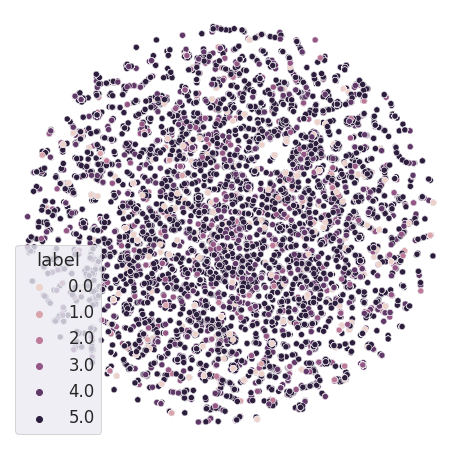

In [ ]:
interaction = pd.read_csv(root_path+'interactions_train.csv')
recipe = pd.read_csv(root_path+'processed_recipes.csv')

pd.set_option('display.max_columns', None) # Show All Columns in Preview
recipe=recipe.rename(columns={"id": "recipe_id"})
data=interaction.join(recipe.set_index('recipe_id'), on='recipe_id')
data=data.dropna()
non_numeric=['user_id','recipe_id','date','u','i','name','contributor_id',
             'submitted','tags','nutrition','steps','description','ingredients',
             'tags_str','ingredients_str','text']
data=data.drop(columns=non_numeric)
X=data[['minutes','n_steps','n_ingredients','calories']]
Y=data[['rating']]
from sklearn.manifold import TSNE
import time
time_start = time.time()

tsne_x = TSNE(n_components=2).fit_transform(X)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

import seaborn as sns
plt.figure(figsize=(8, 8))
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
tsne_data=np.vstack((tsne_x.T,Y.T)).T

num_classes = len(np.unique(Y))
palette = np.array(sns.color_palette("hls", num_classes))
c=palette[Y.astype(np.int)]

data=pd.DataFrame(tsne_data, columns=['Dim1','Dim2','label'])
ax=sns.scatterplot(x='Dim1',y='Dim2',data=data,hue='label')
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')
plt.show()